In [1]:
import numpy as np
import _pickle as pickle
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.initializers as initializers
import random
from matplotlib import animation

In [2]:
class Memory:
    def __init__(self, max_memory):
        self.max_memory = max_memory
        self.samples = []
    
    def add_sample(self, sample):
        self.samples.append(sample)
        if len(self.samples) > self.max_memory:
            self.samples.pop(0)
            
    def sample(self, no_samples):
        if no_samples > len(self.samples):
            return random.sample(self.samples, len(self.samples))
        else:
            return random.sample(self.samples, no_samples)

In [29]:
initializer = initializers.GlorotNormal

x_in = layers.Input(shape = (6400,))
x = layers.Dense(200, kernel_initializer= initializer, activation="relu")(x_in)
x_out = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(x_in, x_out)

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

In [30]:
target_model = model 

target_model.set_weights(model.get_weights())

In [34]:
class GameRunner:
    def __init__(self, env, model, target_model, memory, epsilon, max_eps, min_eps, game_dimensions, 
                 epsilon_greedy_frames, resume = False, render = True):
        self.env = env
        self.model = model
        self.target_model = target_model
        self.memory = memory
        self.eps = epsilon
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.render = render
        self.resume = resume
        self.epsilon_greedy_frames = epsilon_greedy_frames
        self.gameDimensions = game_dimensions
        self.rewards = []
        self.max_x = []
    
    def run(self):
        observation = self.env.reset()
        reward_sum = 0
        prev_frame = None
        episode_number = 0
        recordings = [1, 1000, 2000, 3000, 4000, 5000, 6000]
        frames, ep_rewards = [], []
        count = 0
        
        try:
            with open("DeleteThis.txt", "rb") as fp:   # Unpickling
                running_rewards = pickle.load(fp)
                resume = True
                running_reward = running_rewards[-1]
        except:
            running_rewards = []
            running_reward = None

        
        while True:
            if self.render:
                env.render()

            if self.resume:
                self.model.load_weights("ModelWeights")
            
            if len(running_rewards) in recordings:
                count += 1
            
            curr_frame = self.prepro(observation)
            change_in_frame = curr_frame - prev_frame if prev_frame is not None else np.zeros(self.gameDimensions)
            prev_frame = curr_frame
            
            if (ep_rewards.count(1) + ep_rewards.count(-1) <= 5) and count > 0:
                frames.append(observation)
            
            action, up_prob = self.choose_action(curr_frame)
            
            observation, reward, done, _ = self.env.step(action) 
                
            y = 1 if action == 2 else 0
                        
            self.memory.add_sample((change_in_frame, y - up_prob, reward, done))
            
            # Decay probability of taking random action
            epsilon_interval = (self.max_eps - self.min_eps)
            self.eps -= epsilon_interval / self.epsilon_greedy_frames
            self.eps = max(self.eps, self.min_eps)
            
            reward_sum += reward
            ep_rewards.append(reward)
            
            if done:
                if episode_number % 5 == 0: # Probably should adjust this number
                    self.target_model.set_weights(self.model.get_weights())
                    self.target_model.save_weights("ModelWeights")
                
                accuracy, loss = self.replay(self.memory.samples)
                self.memory.samples = []
                                
                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                print ('resetting env. episode reward total was %f. running mean: %f. avg accuracy: %f. avg loss: %f' % (reward_sum, running_reward, accuracy, loss))
                reward_sum = 0
                observation = env.reset() # reset env
                prev_frame = None
                episode_number += 1
                
                if len(frames) > 0:
                    self.save_frames_as_gif(frames, filename = f'tfModelEp{len(running_rewards)}.gif')
                    
                running_rewards.append(running_reward)

                with open("DeleteThis.txt", "wb") as fp:   #Pickling
                    pickle.dump(running_rewards, fp)
                
                count = 0
                frames = []
                ep_rewards = []
                
                if len(running_rewards) == 6001:
                    break

            if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
                print('ep %d: game finished, reward: %f, epsilon: %g' % (episode_number, reward, self.eps) + ('' if reward == -1 else ' !!!!!!!!'))
                
    def choose_action(self, state):
        if np.random.random() < self.eps:
            randn = np.random.randint(2, 4)
            up_prob = 0
            return np.random.randint(2, 4), up_prob
        else:
            state = state.reshape((1,6400))
            up_prob = self.target_model.predict(state)
            if up_prob >= .5:
                return 2, up_prob
            else:
                return 3, up_prob
    
    def discount_rewards(self, rewards):
        gamma = 0.99
        discounted_r = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, rewards.size)):
            if rewards[t] != 0: running_add = 0
            running_add = running_add * gamma + rewards[t]
            discounted_r[t] = running_add
        return discounted_r
            
    def prepro(self, input_frame):
        input_frame = input_frame[34:194]
        input_frame = input_frame[::2,::2,0]
        input_frame[input_frame == 144] = 0 
        input_frame[input_frame == 109] = 0 
        input_frame[input_frame != 0] = 1 
        return input_frame.astype(np.float).ravel()
    
    def save_frames_as_gif(self, frames, filename):
        patch = plt.imshow(frames[0])
        plt.axis('off')
        def animate(i):
            patch.set_data(frames[i])
        anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
        if filename:
            anim.save(filename, dpi=72, writer='imagemagick')
    
    def replay(self, samples):
        states = np.array([val[0] for val in samples])
        up_probs = np.array([val[1] for val in samples])
        rewards = np.array([val[2] for val in samples])
        
        up_probs = np.vstack(up_probs)
        rewards = np.vstack(rewards)
            
        discount_rewards = self.discount_rewards(rewards)
        discount_rewards -= np.mean(discount_rewards)
        discount_rewards /= np.std(discount_rewards)
        
        up_probs = up_probs * discount_rewards
        
        up_probs = np.asarray(up_probs).astype('float32')
        
        history = self.model.fit(states, up_probs, batch_size = len(samples), verbose = 0, epochs = 50)
        
        return np.mean(history.history["acc"]), np.mean(history.history["loss"])

ep 0: game finished, reward: -1.000000, epsilon: 0.999631
ep 0: game finished, reward: -1.000000, epsilon: 0.999073
ep 0: game finished, reward: -1.000000, epsilon: 0.998857
ep 0: game finished, reward: -1.000000, epsilon: 0.998664
ep 0: game finished, reward: -1.000000, epsilon: 0.998466
ep 0: game finished, reward: -1.000000, epsilon: 0.998245
ep 0: game finished, reward: 1.000000, epsilon: 0.997854 !!!!!!!!
ep 0: game finished, reward: -1.000000, epsilon: 0.997444
ep 0: game finished, reward: -1.000000, epsilon: 0.997228
ep 0: game finished, reward: -1.000000, epsilon: 0.997008
ep 0: game finished, reward: -1.000000, epsilon: 0.99681
ep 0: game finished, reward: -1.000000, epsilon: 0.996612
ep 0: game finished, reward: 1.000000, epsilon: 0.996216 !!!!!!!!
ep 0: game finished, reward: 1.000000, epsilon: 0.995653 !!!!!!!!
ep 0: game finished, reward: -1.000000, epsilon: 0.995266
ep 0: game finished, reward: -1.000000, epsilon: 0.99505
ep 0: game finished, reward: -1.000000, epsilon: 0

<ipython-input-34-41c530eaec0d>:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  up_probs = np.array([val[1] for val in samples])


resetting env. episode reward total was -17.000000. running mean: -17.000000. avg accuracy: 0.492841. avg loss: 0.110026
ep 1: game finished, reward: -1.000000, epsilon: 0.992445
ep 1: game finished, reward: -1.000000, epsilon: 0.991698
ep 1: game finished, reward: -1.000000, epsilon: 0.991486
ep 1: game finished, reward: -1.000000, epsilon: 0.991266
ep 1: game finished, reward: -1.000000, epsilon: 0.991054
ep 1: game finished, reward: -1.000000, epsilon: 0.990852
ep 1: game finished, reward: -1.000000, epsilon: 0.990627
ep 1: game finished, reward: -1.000000, epsilon: 0.990415
ep 1: game finished, reward: -1.000000, epsilon: 0.990208
ep 1: game finished, reward: -1.000000, epsilon: 0.989628
ep 1: game finished, reward: -1.000000, epsilon: 0.989407
ep 1: game finished, reward: -1.000000, epsilon: 0.988822
ep 1: game finished, reward: -1.000000, epsilon: 0.988246
ep 1: game finished, reward: -1.000000, epsilon: 0.988053
ep 1: game finished, reward: -1.000000, epsilon: 0.987832
ep 1: gam

MovieWriter imagemagick unavailable; using Pillow instead.


resetting env. episode reward total was -21.000000. running mean: -17.040000. avg accuracy: 0.478476. avg loss: -0.695349
ep 2: game finished, reward: -1.000000, epsilon: 0.98601
ep 2: game finished, reward: -1.000000, epsilon: 0.985623
ep 2: game finished, reward: -1.000000, epsilon: 0.985411
ep 2: game finished, reward: -1.000000, epsilon: 0.984475
ep 2: game finished, reward: -1.000000, epsilon: 0.984268
ep 2: game finished, reward: -1.000000, epsilon: 0.984057
ep 2: game finished, reward: -1.000000, epsilon: 0.983836
ep 2: game finished, reward: -1.000000, epsilon: 0.983274
ep 2: game finished, reward: -1.000000, epsilon: 0.983067
ep 2: game finished, reward: -1.000000, epsilon: 0.982522
ep 2: game finished, reward: -1.000000, epsilon: 0.982324
ep 2: game finished, reward: -1.000000, epsilon: 0.982135
ep 2: game finished, reward: -1.000000, epsilon: 0.981559
ep 2: game finished, reward: -1.000000, epsilon: 0.981352
ep 2: game finished, reward: 1.000000, epsilon: 0.980938 !!!!!!!!
e

<ipython-input-34-41c530eaec0d>:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  up_probs = np.array([val[1] for val in samples])


resetting env. episode reward total was -20.000000. running mean: -17.069600. avg accuracy: 0.467966. avg loss: -1.034698
ep 3: game finished, reward: -1.000000, epsilon: 0.979084
ep 3: game finished, reward: -1.000000, epsilon: 0.978702
ep 3: game finished, reward: -1.000000, epsilon: 0.978486
ep 3: game finished, reward: -1.000000, epsilon: 0.978274
ep 3: game finished, reward: -1.000000, epsilon: 0.978072
ep 3: game finished, reward: -1.000000, epsilon: 0.97786
ep 3: game finished, reward: -1.000000, epsilon: 0.977649
ep 3: game finished, reward: -1.000000, epsilon: 0.977451
ep 3: game finished, reward: -1.000000, epsilon: 0.977248
ep 3: game finished, reward: -1.000000, epsilon: 0.977037
ep 3: game finished, reward: -1.000000, epsilon: 0.976479
ep 3: game finished, reward: -1.000000, epsilon: 0.976285
ep 3: game finished, reward: -1.000000, epsilon: 0.976074
ep 3: game finished, reward: -1.000000, epsilon: 0.975867
ep 3: game finished, reward: -1.000000, epsilon: 0.975651
ep 3: gam

ep 8: game finished, reward: -1.000000, epsilon: 0.945658
ep 8: game finished, reward: -1.000000, epsilon: 0.94546
resetting env. episode reward total was -20.000000. running mean: -17.250400. avg accuracy: 0.470699. avg loss: -4.668743
ep 9: game finished, reward: -1.000000, epsilon: 0.945253
ep 9: game finished, reward: -1.000000, epsilon: 0.944835
ep 9: game finished, reward: -1.000000, epsilon: 0.944628
ep 9: game finished, reward: -1.000000, epsilon: 0.944425
ep 9: game finished, reward: -1.000000, epsilon: 0.944205
ep 9: game finished, reward: -1.000000, epsilon: 0.943998
ep 9: game finished, reward: -1.000000, epsilon: 0.943786
ep 9: game finished, reward: -1.000000, epsilon: 0.943566
ep 9: game finished, reward: -1.000000, epsilon: 0.943359
ep 9: game finished, reward: -1.000000, epsilon: 0.943147
ep 9: game finished, reward: -1.000000, epsilon: 0.942945
ep 9: game finished, reward: -1.000000, epsilon: 0.942747
ep 9: game finished, reward: -1.000000, epsilon: 0.942549
ep 9: gam

ep 14: game finished, reward: -1.000000, epsilon: 0.908965
ep 14: game finished, reward: -1.000000, epsilon: 0.908749
ep 14: game finished, reward: -1.000000, epsilon: 0.908551
resetting env. episode reward total was -21.000000. running mean: -17.440617. avg accuracy: 0.506658. avg loss: -10.494019
ep 15: game finished, reward: -1.000000, epsilon: 0.908344
ep 15: game finished, reward: -1.000000, epsilon: 0.907575
ep 15: game finished, reward: 1.000000, epsilon: 0.907179 !!!!!!!!
ep 15: game finished, reward: -1.000000, epsilon: 0.906796
ep 15: game finished, reward: -1.000000, epsilon: 0.906229
ep 15: game finished, reward: -1.000000, epsilon: 0.906004
ep 15: game finished, reward: -1.000000, epsilon: 0.905797
ep 15: game finished, reward: -1.000000, epsilon: 0.905599
ep 15: game finished, reward: -1.000000, epsilon: 0.90537
ep 15: game finished, reward: -1.000000, epsilon: 0.905172
ep 15: game finished, reward: -1.000000, epsilon: 0.90496
ep 15: game finished, reward: -1.000000, epsi

ep 20: game finished, reward: -1.000000, epsilon: 0.874054
ep 20: game finished, reward: -1.000000, epsilon: 0.873852
ep 20: game finished, reward: -1.000000, epsilon: 0.87364
ep 20: game finished, reward: -1.000000, epsilon: 0.873433
ep 20: game finished, reward: -1.000000, epsilon: 0.873231
resetting env. episode reward total was -21.000000. running mean: -17.619800. avg accuracy: 0.539648. avg loss: -42.046436
ep 21: game finished, reward: -1.000000, epsilon: 0.873015
ep 21: game finished, reward: -1.000000, epsilon: 0.872259
ep 21: game finished, reward: -1.000000, epsilon: 0.87207
ep 21: game finished, reward: -1.000000, epsilon: 0.871863
ep 21: game finished, reward: -1.000000, epsilon: 0.871669
ep 21: game finished, reward: -1.000000, epsilon: 0.871458
ep 21: game finished, reward: -1.000000, epsilon: 0.871251
ep 21: game finished, reward: -1.000000, epsilon: 0.87067
ep 21: game finished, reward: -1.000000, epsilon: 0.870463
ep 21: game finished, reward: -1.000000, epsilon: 0.87

ep 26: game finished, reward: -1.000000, epsilon: 0.840979
ep 26: game finished, reward: -1.000000, epsilon: 0.840772
ep 26: game finished, reward: -1.000000, epsilon: 0.840565
ep 26: game finished, reward: -1.000000, epsilon: 0.840354
ep 26: game finished, reward: -1.000000, epsilon: 0.839773
ep 26: game finished, reward: -1.000000, epsilon: 0.839557
ep 26: game finished, reward: -1.000000, epsilon: 0.83935
resetting env. episode reward total was -21.000000. running mean: -17.788597. avg accuracy: 0.538680. avg loss: -64.670770
ep 27: game finished, reward: -1.000000, epsilon: 0.839134
ep 27: game finished, reward: -1.000000, epsilon: 0.838752
ep 27: game finished, reward: -1.000000, epsilon: 0.838522
ep 27: game finished, reward: -1.000000, epsilon: 0.838306
ep 27: game finished, reward: -1.000000, epsilon: 0.83809
ep 27: game finished, reward: -1.000000, epsilon: 0.837901
ep 27: game finished, reward: -1.000000, epsilon: 0.837703
ep 27: game finished, reward: -1.000000, epsilon: 0.8

ep 32: game finished, reward: -1.000000, epsilon: 0.809263
ep 32: game finished, reward: -1.000000, epsilon: 0.809047
ep 32: game finished, reward: -1.000000, epsilon: 0.808827
ep 32: game finished, reward: -1.000000, epsilon: 0.808602
ep 32: game finished, reward: -1.000000, epsilon: 0.80839
ep 32: game finished, reward: -1.000000, epsilon: 0.808179
ep 32: game finished, reward: 1.000000, epsilon: 0.807778 !!!!!!!!
ep 32: game finished, reward: -1.000000, epsilon: 0.807013
resetting env. episode reward total was -20.000000. running mean: -17.956825. avg accuracy: 0.586153. avg loss: -46.346493
ep 33: game finished, reward: -1.000000, epsilon: 0.806797
ep 33: game finished, reward: -1.000000, epsilon: 0.806419
ep 33: game finished, reward: -1.000000, epsilon: 0.806203
ep 33: game finished, reward: -1.000000, epsilon: 0.806001
ep 33: game finished, reward: -1.000000, epsilon: 0.805785
ep 33: game finished, reward: -1.000000, epsilon: 0.805596
ep 33: game finished, reward: -1.000000, eps

ep 38: game finished, reward: -1.000000, epsilon: 0.77748
ep 38: game finished, reward: -1.000000, epsilon: 0.777273
ep 38: game finished, reward: -1.000000, epsilon: 0.77707
ep 38: game finished, reward: -1.000000, epsilon: 0.776863
ep 38: game finished, reward: -1.000000, epsilon: 0.776647
ep 38: game finished, reward: -1.000000, epsilon: 0.77644
ep 38: game finished, reward: -1.000000, epsilon: 0.776233
ep 38: game finished, reward: -1.000000, epsilon: 0.776022
ep 38: game finished, reward: -1.000000, epsilon: 0.775815
resetting env. episode reward total was -21.000000. running mean: -18.115309. avg accuracy: 0.599000. avg loss: -193.901086
ep 39: game finished, reward: -1.000000, epsilon: 0.775608
ep 39: game finished, reward: -1.000000, epsilon: 0.775239
ep 39: game finished, reward: -1.000000, epsilon: 0.775041
ep 39: game finished, reward: -1.000000, epsilon: 0.774829
ep 39: game finished, reward: -1.000000, epsilon: 0.774604
ep 39: game finished, reward: -1.000000, epsilon: 0.7

ep 44: game finished, reward: -1.000000, epsilon: 0.748644
ep 44: game finished, reward: -1.000000, epsilon: 0.748423
ep 44: game finished, reward: -1.000000, epsilon: 0.748203
ep 44: game finished, reward: -1.000000, epsilon: 0.747996
ep 44: game finished, reward: -1.000000, epsilon: 0.747793
ep 44: game finished, reward: -1.000000, epsilon: 0.747582
ep 44: game finished, reward: -1.000000, epsilon: 0.747375
ep 44: game finished, reward: -1.000000, epsilon: 0.747154
ep 44: game finished, reward: -1.000000, epsilon: 0.746943
resetting env. episode reward total was -21.000000. running mean: -18.274611. avg accuracy: 0.583483. avg loss: -230.423718
ep 45: game finished, reward: -1.000000, epsilon: 0.746727
ep 45: game finished, reward: -1.000000, epsilon: 0.746331
ep 45: game finished, reward: -1.000000, epsilon: 0.746119
ep 45: game finished, reward: -1.000000, epsilon: 0.745921
ep 45: game finished, reward: -1.000000, epsilon: 0.745692
ep 45: game finished, reward: -1.000000, epsilon: 

ep 50: game finished, reward: -1.000000, epsilon: 0.720231
ep 50: game finished, reward: -1.000000, epsilon: 0.720024
ep 50: game finished, reward: -1.000000, epsilon: 0.719817
ep 50: game finished, reward: -1.000000, epsilon: 0.719601
ep 50: game finished, reward: -1.000000, epsilon: 0.719403
ep 50: game finished, reward: -1.000000, epsilon: 0.7192
ep 50: game finished, reward: -1.000000, epsilon: 0.718993
ep 50: game finished, reward: -1.000000, epsilon: 0.718777
resetting env. episode reward total was -21.000000. running mean: -18.434100. avg accuracy: 0.603526. avg loss: -234.206713
ep 51: game finished, reward: -1.000000, epsilon: 0.718561
ep 51: game finished, reward: -1.000000, epsilon: 0.718197
ep 51: game finished, reward: -1.000000, epsilon: 0.717981
ep 51: game finished, reward: -1.000000, epsilon: 0.717769
ep 51: game finished, reward: -1.000000, epsilon: 0.71754
ep 51: game finished, reward: -1.000000, epsilon: 0.71731
ep 51: game finished, reward: -1.000000, epsilon: 0.71

ep 56: game finished, reward: -1.000000, epsilon: 0.69045
ep 56: game finished, reward: -1.000000, epsilon: 0.690229
ep 56: game finished, reward: -1.000000, epsilon: 0.689658
ep 56: game finished, reward: -1.000000, epsilon: 0.689451
ep 56: game finished, reward: -1.000000, epsilon: 0.689248
ep 56: game finished, reward: -1.000000, epsilon: 0.688681
ep 56: game finished, reward: -1.000000, epsilon: 0.688465
ep 56: game finished, reward: -1.000000, epsilon: 0.688249
resetting env. episode reward total was -21.000000. running mean: -18.574746. avg accuracy: 0.630285. avg loss: -235.646984
ep 57: game finished, reward: -1.000000, epsilon: 0.688029
ep 57: game finished, reward: -1.000000, epsilon: 0.687655
ep 57: game finished, reward: -1.000000, epsilon: 0.687448
ep 57: game finished, reward: -1.000000, epsilon: 0.687241
ep 57: game finished, reward: -1.000000, epsilon: 0.687039
ep 57: game finished, reward: -1.000000, epsilon: 0.686845
ep 57: game finished, reward: -1.000000, epsilon: 0

ep 62: game finished, reward: -1.000000, epsilon: 0.6621
ep 62: game finished, reward: -1.000000, epsilon: 0.661897
ep 62: game finished, reward: -1.000000, epsilon: 0.661695
ep 62: game finished, reward: -1.000000, epsilon: 0.661483
ep 62: game finished, reward: -1.000000, epsilon: 0.661281
ep 62: game finished, reward: -1.000000, epsilon: 0.661069
ep 62: game finished, reward: -1.000000, epsilon: 0.660867
resetting env. episode reward total was -21.000000. running mean: -18.716672. avg accuracy: 0.619565. avg loss: -431.229106
ep 63: game finished, reward: -1.000000, epsilon: 0.660664
ep 63: game finished, reward: -1.000000, epsilon: 0.660277
ep 63: game finished, reward: -1.000000, epsilon: 0.660066
ep 63: game finished, reward: -1.000000, epsilon: 0.659854
ep 63: game finished, reward: -1.000000, epsilon: 0.659629
ep 63: game finished, reward: -1.000000, epsilon: 0.659436
ep 63: game finished, reward: -1.000000, epsilon: 0.65922
ep 63: game finished, reward: -1.000000, epsilon: 0.6

ep 68: game finished, reward: -1.000000, epsilon: 0.634353
ep 68: game finished, reward: -1.000000, epsilon: 0.634141
ep 68: game finished, reward: -1.000000, epsilon: 0.633934
ep 68: game finished, reward: -1.000000, epsilon: 0.633723
ep 68: game finished, reward: -1.000000, epsilon: 0.633525
ep 68: game finished, reward: -1.000000, epsilon: 0.633309
resetting env. episode reward total was -21.000000. running mean: -18.850292. avg accuracy: 0.647342. avg loss: -543.751262
ep 69: game finished, reward: -1.000000, epsilon: 0.633093
ep 69: game finished, reward: -1.000000, epsilon: 0.632679
ep 69: game finished, reward: -1.000000, epsilon: 0.632476
ep 69: game finished, reward: -1.000000, epsilon: 0.632265
ep 69: game finished, reward: -1.000000, epsilon: 0.632049
ep 69: game finished, reward: -1.000000, epsilon: 0.631842
ep 69: game finished, reward: -1.000000, epsilon: 0.631635
ep 69: game finished, reward: -1.000000, epsilon: 0.631432
ep 69: game finished, reward: -1.000000, epsilon: 

ep 74: game finished, reward: -1.000000, epsilon: 0.606534
ep 74: game finished, reward: -1.000000, epsilon: 0.606322
ep 74: game finished, reward: -1.000000, epsilon: 0.606115
ep 74: game finished, reward: -1.000000, epsilon: 0.605899
ep 74: game finished, reward: -1.000000, epsilon: 0.605692
resetting env. episode reward total was -21.000000. running mean: -18.976092. avg accuracy: 0.636023. avg loss: -536.814651
ep 75: game finished, reward: -1.000000, epsilon: 0.605494
ep 75: game finished, reward: -1.000000, epsilon: 0.605125
ep 75: game finished, reward: -1.000000, epsilon: 0.604918
ep 75: game finished, reward: -1.000000, epsilon: 0.604707
ep 75: game finished, reward: -1.000000, epsilon: 0.604495
ep 75: game finished, reward: -1.000000, epsilon: 0.604261
ep 75: game finished, reward: -1.000000, epsilon: 0.604054
ep 75: game finished, reward: -1.000000, epsilon: 0.603838
ep 75: game finished, reward: -1.000000, epsilon: 0.603622
ep 75: game finished, reward: -1.000000, epsilon: 

ep 80: game finished, reward: -1.000000, epsilon: 0.578998
ep 80: game finished, reward: -1.000000, epsilon: 0.578796
ep 80: game finished, reward: -1.000000, epsilon: 0.578584
ep 80: game finished, reward: -1.000000, epsilon: 0.578368
resetting env. episode reward total was -21.000000. running mean: -19.094531. avg accuracy: 0.662849. avg loss: -833.918441
ep 81: game finished, reward: -1.000000, epsilon: 0.578148
ep 81: game finished, reward: -1.000000, epsilon: 0.577761
ep 81: game finished, reward: -1.000000, epsilon: 0.577549
ep 81: game finished, reward: -1.000000, epsilon: 0.577329
ep 81: game finished, reward: -1.000000, epsilon: 0.577122
ep 81: game finished, reward: -1.000000, epsilon: 0.57691
ep 81: game finished, reward: -1.000000, epsilon: 0.576712
ep 81: game finished, reward: -1.000000, epsilon: 0.576519
ep 81: game finished, reward: -1.000000, epsilon: 0.576316
ep 81: game finished, reward: -1.000000, epsilon: 0.576123
ep 81: game finished, reward: -1.000000, epsilon: 0

ep 86: game finished, reward: -1.000000, epsilon: 0.551166
ep 86: game finished, reward: -1.000000, epsilon: 0.550954
ep 86: game finished, reward: -1.000000, epsilon: 0.550747
resetting env. episode reward total was -21.000000. running mean: -19.206039. avg accuracy: 0.693184. avg loss: -730.416904
ep 87: game finished, reward: -1.000000, epsilon: 0.550536
ep 87: game finished, reward: -1.000000, epsilon: 0.550162
ep 87: game finished, reward: -1.000000, epsilon: 0.549951
ep 87: game finished, reward: -1.000000, epsilon: 0.549744
ep 87: game finished, reward: -1.000000, epsilon: 0.549532
ep 87: game finished, reward: -1.000000, epsilon: 0.549325
ep 87: game finished, reward: -1.000000, epsilon: 0.549114
ep 87: game finished, reward: -1.000000, epsilon: 0.548893
ep 87: game finished, reward: -1.000000, epsilon: 0.548691
ep 87: game finished, reward: -1.000000, epsilon: 0.548484
ep 87: game finished, reward: -1.000000, epsilon: 0.548281
ep 87: game finished, reward: -1.000000, epsilon: 

ep 92: game finished, reward: -1.000000, epsilon: 0.52354
ep 92: game finished, reward: -1.000000, epsilon: 0.523324
resetting env. episode reward total was -21.000000. running mean: -19.311021. avg accuracy: 0.713183. avg loss: -753.921396
ep 93: game finished, reward: -1.000000, epsilon: 0.523122
ep 93: game finished, reward: -1.000000, epsilon: 0.522735
ep 93: game finished, reward: -1.000000, epsilon: 0.522546
ep 93: game finished, reward: -1.000000, epsilon: 0.522325
ep 93: game finished, reward: -1.000000, epsilon: 0.522114
ep 93: game finished, reward: -1.000000, epsilon: 0.521907
ep 93: game finished, reward: -1.000000, epsilon: 0.521686
ep 93: game finished, reward: -1.000000, epsilon: 0.521475
ep 93: game finished, reward: -1.000000, epsilon: 0.521272
ep 93: game finished, reward: -1.000000, epsilon: 0.521052
ep 93: game finished, reward: -1.000000, epsilon: 0.520849
ep 93: game finished, reward: -1.000000, epsilon: 0.520647
ep 93: game finished, reward: -1.000000, epsilon: 0

ep 98: game finished, reward: -1.000000, epsilon: 0.496
resetting env. episode reward total was -21.000000. running mean: -19.409860. avg accuracy: 0.738810. avg loss: -522.011444
ep 99: game finished, reward: -1.000000, epsilon: 0.495784
ep 99: game finished, reward: -1.000000, epsilon: 0.495393
ep 99: game finished, reward: -1.000000, epsilon: 0.495181
ep 99: game finished, reward: -1.000000, epsilon: 0.494974
ep 99: game finished, reward: -1.000000, epsilon: 0.494758
ep 99: game finished, reward: -1.000000, epsilon: 0.494533
ep 99: game finished, reward: -1.000000, epsilon: 0.494317
ep 99: game finished, reward: -1.000000, epsilon: 0.49411
ep 99: game finished, reward: -1.000000, epsilon: 0.493903
ep 99: game finished, reward: -1.000000, epsilon: 0.493696
ep 99: game finished, reward: -1.000000, epsilon: 0.493498
ep 99: game finished, reward: -1.000000, epsilon: 0.493287
ep 99: game finished, reward: -1.000000, epsilon: 0.493075
ep 99: game finished, reward: -1.000000, epsilon: 0.49

ep 104: game finished, reward: -1.000000, epsilon: 0.468573
ep 104: game finished, reward: -1.000000, epsilon: 0.468352
resetting env. episode reward total was -21.000000. running mean: -19.502915. avg accuracy: 0.726846. avg loss: -917.650313
ep 105: game finished, reward: -1.000000, epsilon: 0.468154
ep 105: game finished, reward: -1.000000, epsilon: 0.467763
ep 105: game finished, reward: -1.000000, epsilon: 0.467547
ep 105: game finished, reward: -1.000000, epsilon: 0.467331
ep 105: game finished, reward: -1.000000, epsilon: 0.467106
ep 105: game finished, reward: -1.000000, epsilon: 0.466899
ep 105: game finished, reward: -1.000000, epsilon: 0.466683
ep 105: game finished, reward: -1.000000, epsilon: 0.466462
ep 105: game finished, reward: -1.000000, epsilon: 0.46626
ep 105: game finished, reward: -1.000000, epsilon: 0.466066
ep 105: game finished, reward: -1.000000, epsilon: 0.465855
ep 105: game finished, reward: -1.000000, epsilon: 0.465643
ep 105: game finished, reward: -1.000

ep 110: game finished, reward: -1.000000, epsilon: 0.441312
ep 110: game finished, reward: -1.000000, epsilon: 0.441087
ep 110: game finished, reward: -1.000000, epsilon: 0.440889
resetting env. episode reward total was -21.000000. running mean: -19.590524. avg accuracy: 0.760000. avg loss: -974.904884
ep 111: game finished, reward: -1.000000, epsilon: 0.440668
ep 111: game finished, reward: -1.000000, epsilon: 0.440268
ep 111: game finished, reward: -1.000000, epsilon: 0.440047
ep 111: game finished, reward: -1.000000, epsilon: 0.439845
ep 111: game finished, reward: -1.000000, epsilon: 0.439638
ep 111: game finished, reward: -1.000000, epsilon: 0.439435
ep 111: game finished, reward: -1.000000, epsilon: 0.439219
ep 111: game finished, reward: -1.000000, epsilon: 0.439021
ep 111: game finished, reward: -1.000000, epsilon: 0.438801
ep 111: game finished, reward: -1.000000, epsilon: 0.43858
ep 111: game finished, reward: -1.000000, epsilon: 0.438373
ep 111: game finished, reward: -1.000

ep 116: game finished, reward: -1.000000, epsilon: 0.414114
ep 116: game finished, reward: -1.000000, epsilon: 0.413902
ep 116: game finished, reward: -1.000000, epsilon: 0.413677
ep 116: game finished, reward: -1.000000, epsilon: 0.413475
resetting env. episode reward total was -21.000000. running mean: -19.673006. avg accuracy: 0.759626. avg loss: -680.098756
ep 117: game finished, reward: -1.000000, epsilon: 0.413263
ep 117: game finished, reward: -1.000000, epsilon: 0.412885
ep 117: game finished, reward: -1.000000, epsilon: 0.412687
ep 117: game finished, reward: -1.000000, epsilon: 0.412471
ep 117: game finished, reward: -1.000000, epsilon: 0.412255
ep 117: game finished, reward: -1.000000, epsilon: 0.41203
ep 117: game finished, reward: -1.000000, epsilon: 0.411832
ep 117: game finished, reward: -1.000000, epsilon: 0.411621
ep 117: game finished, reward: -1.000000, epsilon: 0.411409
ep 117: game finished, reward: -1.000000, epsilon: 0.411171
ep 117: game finished, reward: -1.000

ep 122: game finished, reward: -1.000000, epsilon: 0.386718
ep 122: game finished, reward: -1.000000, epsilon: 0.386506
ep 122: game finished, reward: -1.000000, epsilon: 0.38629
ep 122: game finished, reward: -1.000000, epsilon: 0.38607
ep 122: game finished, reward: -1.000000, epsilon: 0.385863
resetting env. episode reward total was -21.000000. running mean: -19.750662. avg accuracy: 0.765237. avg loss: -754.944910
ep 123: game finished, reward: -1.000000, epsilon: 0.385647
ep 123: game finished, reward: -1.000000, epsilon: 0.385251
ep 123: game finished, reward: -1.000000, epsilon: 0.385035
ep 123: game finished, reward: -1.000000, epsilon: 0.384819
ep 123: game finished, reward: -1.000000, epsilon: 0.384612
ep 123: game finished, reward: -1.000000, epsilon: 0.384396
ep 123: game finished, reward: -1.000000, epsilon: 0.38418
ep 123: game finished, reward: -1.000000, epsilon: 0.383959
ep 123: game finished, reward: -1.000000, epsilon: 0.383743
ep 123: game finished, reward: -1.00000

ep 128: game finished, reward: -1.000000, epsilon: 0.359245
ep 128: game finished, reward: -1.000000, epsilon: 0.359047
ep 128: game finished, reward: -1.000000, epsilon: 0.35884
ep 128: game finished, reward: -1.000000, epsilon: 0.358624
ep 128: game finished, reward: -1.000000, epsilon: 0.358422
ep 128: game finished, reward: -1.000000, epsilon: 0.35821
resetting env. episode reward total was -21.000000. running mean: -19.823773. avg accuracy: 0.775163. avg loss: -1025.883439
ep 129: game finished, reward: -1.000000, epsilon: 0.358003
ep 129: game finished, reward: -1.000000, epsilon: 0.357625
ep 129: game finished, reward: -1.000000, epsilon: 0.357414
ep 129: game finished, reward: -1.000000, epsilon: 0.357207
ep 129: game finished, reward: -1.000000, epsilon: 0.356995
ep 129: game finished, reward: -1.000000, epsilon: 0.356793
ep 129: game finished, reward: -1.000000, epsilon: 0.356572
ep 129: game finished, reward: -1.000000, epsilon: 0.356374
ep 129: game finished, reward: -1.000

ep 134: game finished, reward: -1.000000, epsilon: 0.331827
ep 134: game finished, reward: -1.000000, epsilon: 0.331624
ep 134: game finished, reward: -1.000000, epsilon: 0.331413
ep 134: game finished, reward: -1.000000, epsilon: 0.331215
ep 134: game finished, reward: -1.000000, epsilon: 0.331003
ep 134: game finished, reward: -1.000000, epsilon: 0.330792
ep 134: game finished, reward: -1.000000, epsilon: 0.33058
resetting env. episode reward total was -21.000000. running mean: -19.892606. avg accuracy: 0.790391. avg loss: -1062.447874
ep 135: game finished, reward: -1.000000, epsilon: 0.330378
ep 135: game finished, reward: -1.000000, epsilon: 0.329977
ep 135: game finished, reward: -1.000000, epsilon: 0.329779
ep 135: game finished, reward: -1.000000, epsilon: 0.329563
ep 135: game finished, reward: -1.000000, epsilon: 0.329334
ep 135: game finished, reward: -1.000000, epsilon: 0.329122
ep 135: game finished, reward: -1.000000, epsilon: 0.328911
ep 135: game finished, reward: -1.00

ep 140: game finished, reward: -1.000000, epsilon: 0.304602
ep 140: game finished, reward: -1.000000, epsilon: 0.304399
ep 140: game finished, reward: -1.000000, epsilon: 0.304179
ep 140: game finished, reward: -1.000000, epsilon: 0.303972
ep 140: game finished, reward: -1.000000, epsilon: 0.303769
ep 140: game finished, reward: -1.000000, epsilon: 0.303553
ep 140: game finished, reward: -1.000000, epsilon: 0.303342
ep 140: game finished, reward: -1.000000, epsilon: 0.303135
resetting env. episode reward total was -21.000000. running mean: -19.957410. avg accuracy: 0.796979. avg loss: -1043.324835
ep 141: game finished, reward: -1.000000, epsilon: 0.302937
ep 141: game finished, reward: -1.000000, epsilon: 0.302554
ep 141: game finished, reward: -1.000000, epsilon: 0.302343
ep 141: game finished, reward: -1.000000, epsilon: 0.302136
ep 141: game finished, reward: -1.000000, epsilon: 0.301911
ep 141: game finished, reward: -1.000000, epsilon: 0.301713
ep 141: game finished, reward: -1.0

ep 146: game finished, reward: -1.000000, epsilon: 0.277242
ep 146: game finished, reward: -1.000000, epsilon: 0.277026
ep 146: game finished, reward: -1.000000, epsilon: 0.276805
ep 146: game finished, reward: -1.000000, epsilon: 0.276603
ep 146: game finished, reward: -1.000000, epsilon: 0.276405
ep 146: game finished, reward: -1.000000, epsilon: 0.276198
ep 146: game finished, reward: -1.000000, epsilon: 0.275991
ep 146: game finished, reward: -1.000000, epsilon: 0.275784
ep 146: game finished, reward: -1.000000, epsilon: 0.275577
resetting env. episode reward total was -21.000000. running mean: -20.018422. avg accuracy: 0.846413. avg loss: -719.921279
ep 147: game finished, reward: -1.000000, epsilon: 0.275365
ep 147: game finished, reward: -1.000000, epsilon: 0.274996
ep 147: game finished, reward: -1.000000, epsilon: 0.274785
ep 147: game finished, reward: -1.000000, epsilon: 0.274564
ep 147: game finished, reward: -1.000000, epsilon: 0.274357
ep 147: game finished, reward: -1.00

ep 152: game finished, reward: -1.000000, epsilon: 0.249954
ep 152: game finished, reward: -1.000000, epsilon: 0.249733
ep 152: game finished, reward: -1.000000, epsilon: 0.249517
ep 152: game finished, reward: -1.000000, epsilon: 0.249292
ep 152: game finished, reward: -1.000000, epsilon: 0.249072
ep 152: game finished, reward: -1.000000, epsilon: 0.248869
ep 152: game finished, reward: -1.000000, epsilon: 0.24868
ep 152: game finished, reward: -1.000000, epsilon: 0.248469
ep 152: game finished, reward: -1.000000, epsilon: 0.248262
ep 152: game finished, reward: -1.000000, epsilon: 0.248041
resetting env. episode reward total was -21.000000. running mean: -20.075864. avg accuracy: 0.848423. avg loss: -600.524126
ep 153: game finished, reward: -1.000000, epsilon: 0.247825
ep 153: game finished, reward: -1.000000, epsilon: 0.247429
ep 153: game finished, reward: -1.000000, epsilon: 0.247231
ep 153: game finished, reward: -1.000000, epsilon: 0.247024
ep 153: game finished, reward: -1.000

ep 158: game finished, reward: -1.000000, epsilon: 0.222517
ep 158: game finished, reward: -1.000000, epsilon: 0.22231
ep 158: game finished, reward: -1.000000, epsilon: 0.222103
ep 158: game finished, reward: -1.000000, epsilon: 0.221896
ep 158: game finished, reward: -1.000000, epsilon: 0.22168
ep 158: game finished, reward: -1.000000, epsilon: 0.221469
ep 158: game finished, reward: -1.000000, epsilon: 0.221262
ep 158: game finished, reward: -1.000000, epsilon: 0.221055
ep 158: game finished, reward: -1.000000, epsilon: 0.220852
ep 158: game finished, reward: -1.000000, epsilon: 0.220636
ep 158: game finished, reward: -1.000000, epsilon: 0.22042
resetting env. episode reward total was -21.000000. running mean: -20.129944. avg accuracy: 0.860117. avg loss: -605.338318
ep 159: game finished, reward: -1.000000, epsilon: 0.220204
ep 159: game finished, reward: -1.000000, epsilon: 0.219813
ep 159: game finished, reward: -1.000000, epsilon: 0.219601
ep 159: game finished, reward: -1.00000

ep 164: game finished, reward: -1.000000, epsilon: 0.195346
ep 164: game finished, reward: -1.000000, epsilon: 0.195135
ep 164: game finished, reward: -1.000000, epsilon: 0.194919
ep 164: game finished, reward: -1.000000, epsilon: 0.194716
ep 164: game finished, reward: -1.000000, epsilon: 0.194509
ep 164: game finished, reward: -1.000000, epsilon: 0.194307
ep 164: game finished, reward: -1.000000, epsilon: 0.194086
ep 164: game finished, reward: -1.000000, epsilon: 0.193875
ep 164: game finished, reward: -1.000000, epsilon: 0.193663
ep 164: game finished, reward: -1.000000, epsilon: 0.193447
ep 164: game finished, reward: -1.000000, epsilon: 0.193231
ep 164: game finished, reward: -1.000000, epsilon: 0.19302
resetting env. episode reward total was -21.000000. running mean: -20.180860. avg accuracy: 0.883106. avg loss: -499.849810
ep 165: game finished, reward: -1.000000, epsilon: 0.192808
ep 165: game finished, reward: -1.000000, epsilon: 0.192412
ep 165: game finished, reward: -1.000

ep 170: game finished, reward: -1.000000, epsilon: 0.168081
ep 170: game finished, reward: -1.000000, epsilon: 0.167883
ep 170: game finished, reward: -1.000000, epsilon: 0.167676
ep 170: game finished, reward: -1.000000, epsilon: 0.167478
ep 170: game finished, reward: -1.000000, epsilon: 0.167275
ep 170: game finished, reward: -1.000000, epsilon: 0.167073
ep 170: game finished, reward: -1.000000, epsilon: 0.166866
ep 170: game finished, reward: -1.000000, epsilon: 0.166668
ep 170: game finished, reward: -1.000000, epsilon: 0.166461
ep 170: game finished, reward: -1.000000, epsilon: 0.166258
ep 170: game finished, reward: -1.000000, epsilon: 0.166042
ep 170: game finished, reward: -1.000000, epsilon: 0.16584
ep 170: game finished, reward: -1.000000, epsilon: 0.165624
resetting env. episode reward total was -21.000000. running mean: -20.228796. avg accuracy: 0.898229. avg loss: -757.900099
ep 171: game finished, reward: -1.000000, epsilon: 0.165403
ep 171: game finished, reward: -1.000

ep 176: game finished, reward: -1.000000, epsilon: 0.140824
ep 176: game finished, reward: -1.000000, epsilon: 0.140617
ep 176: game finished, reward: -1.000000, epsilon: 0.140406
ep 176: game finished, reward: -1.000000, epsilon: 0.140199
ep 176: game finished, reward: -1.000000, epsilon: 0.139969
ep 176: game finished, reward: -1.000000, epsilon: 0.139753
ep 176: game finished, reward: -1.000000, epsilon: 0.139546
ep 176: game finished, reward: -1.000000, epsilon: 0.13933
ep 176: game finished, reward: -1.000000, epsilon: 0.139128
ep 176: game finished, reward: -1.000000, epsilon: 0.138916
ep 176: game finished, reward: -1.000000, epsilon: 0.1387
ep 176: game finished, reward: -1.000000, epsilon: 0.138475
ep 176: game finished, reward: -1.000000, epsilon: 0.138268
ep 176: game finished, reward: -1.000000, epsilon: 0.138052
resetting env. episode reward total was -21.000000. running mean: -20.273927. avg accuracy: 0.923603. avg loss: -520.027639
ep 177: game finished, reward: -1.00000

ep 182: game finished, reward: -1.000000, epsilon: 0.11346
ep 182: game finished, reward: -1.000000, epsilon: 0.113248
ep 182: game finished, reward: -1.000000, epsilon: 0.113046
ep 182: game finished, reward: -1.000000, epsilon: 0.112843
ep 182: game finished, reward: -1.000000, epsilon: 0.112636
ep 182: game finished, reward: -1.000000, epsilon: 0.112425
ep 182: game finished, reward: -1.000000, epsilon: 0.112213
ep 182: game finished, reward: -1.000000, epsilon: 0.11202
ep 182: game finished, reward: -1.000000, epsilon: 0.111804
ep 182: game finished, reward: -1.000000, epsilon: 0.111592
ep 182: game finished, reward: -1.000000, epsilon: 0.111385
ep 182: game finished, reward: -1.000000, epsilon: 0.111174
ep 182: game finished, reward: -1.000000, epsilon: 0.110971
ep 182: game finished, reward: -1.000000, epsilon: 0.11076
ep 182: game finished, reward: -1.000000, epsilon: 0.110562
resetting env. episode reward total was -21.000000. running mean: -20.316416. avg accuracy: 0.926752. a

ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
ep 188: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean: -20.356420. avg accuracy: 0.917936. avg loss: -555.525524
ep 189: game finished, reward: -1.000000, epsilon: 0.1
ep 189: game finished, reward: -1.000000, epsilon: 0.1
ep 189: game finished, reward: -1.000000, epsilon: 0.1
ep 189: game finished, reward: -1.000000, epsilon: 0.1
ep 189: game finished, reward: -1.000000, epsilon: 

ep 194: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean: -20.394082. avg accuracy: 0.928462. avg loss: -389.304258
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 0.1
ep 195: game finished, reward: -1.000000, epsilon: 

ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
ep 201: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean: -20.435245. avg accuracy: 0.943297. avg loss: -393.031952
ep 202: game finished, reward: -1.000000, epsilon: 0.1
ep 202: game finished, reward: -1.000000, epsilon: 

ep 207: game finished, reward: -1.000000, epsilon: 0.1
ep 207: game finished, reward: -1.000000, epsilon: 0.1
ep 207: game finished, reward: -1.000000, epsilon: 0.1
ep 207: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean: -20.468294. avg accuracy: 0.938939. avg loss: -345.828586
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 0.1
ep 208: game finished, reward: -1.000000, epsilon: 

ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
ep 214: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean:

ep 220: game finished, reward: -1.000000, epsilon: 0.1
ep 220: game finished, reward: -1.000000, epsilon: 0.1
ep 220: game finished, reward: -1.000000, epsilon: 0.1
ep 220: game finished, reward: -1.000000, epsilon: 0.1
ep 220: game finished, reward: -1.000000, epsilon: 0.1
ep 220: game finished, reward: -1.000000, epsilon: 0.1
ep 220: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean: -20.533417. avg accuracy: 0.929463. avg loss: -596.699480
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 0.1
ep 221: game finished, reward: -1.000000, epsilon: 

ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: game finished, reward: -1.000000, epsilon: 0.1
ep 227: ga

ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
ep 233: game finished, reward: -1.000000, epsilon: 0.1
resetting env. episode reward total was -21.000000. running mean: -20.590563. avg accuracy: 0.929722. avg loss: -895.556077
ep 234: game finished, reward: -1.000000, epsilon: 0.1
ep 234: game finished, reward: -1.000000, epsilon: 0.1
ep 234: game finished, reward: -1.000000, epsilon: 0.1
ep 234: game finished, reward: -1.000000, epsilon: 0.1
ep 234: game finished, reward: -1.000000, epsilon: 0.1
ep 234: game finished, reward: -1.000000, epsilon: 

resetting env. episode reward total was -21.000000. running mean: -20.614524. avg accuracy: 0.931547. avg loss: -696.430552
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 0.1
ep 240: game finished, reward: -1.000000, epsilon: 

ep 246: game finished, reward: -1.000000, epsilon: 0.1


KeyboardInterrupt: 

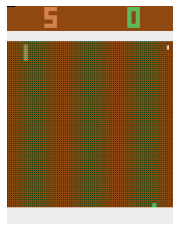

In [35]:
env = gym.make("Pong-v0")

mem = Memory(50_000)

eps = 1.0
max_eps = 1.0
min_eps = 0.1
eps_greedy_frames = 200000.0

game_dimensions = 80*80

gr = GameRunner(env, model, target_model, mem, eps, max_eps, min_eps, game_dimensions, 
                eps_greedy_frames, resume = False, render = False)

gr.run()

In [7]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [8]:
env.unwrapped.get_action_meanings()

# NOOP is the same as FIRE (standing still)
# LEFT is the same as LEFTFIRE (down)
# RIGHT is the same as RIGHTFIRE (up)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [9]:
env.unwrapped.get_keys_to_action()

{(): 0, (32,): 1, (100,): 2, (97,): 3, (32, 100): 4, (32, 97): 5}

In [19]:
with open("ControlRRLR1e-3.txt", "rb") as fp:   # Unpickling
        running_rewards = pickle.load(fp)

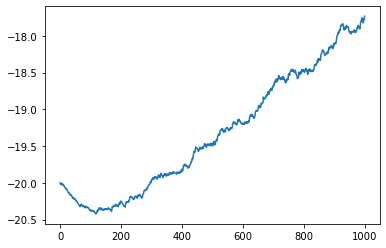

In [28]:
fig = plt.figure()
plt.plot(range(1000), running_rewards[:1000])
plt.show()